<h1 align=center><font size = 5>Machine Learning models for aiding the decision-making process in emergency departments</font></h1>

<h1>Tabla comparativa de algoritmos<h1>
<h3>Descripción</h3>
<p>
En este script se desarrollará una serie de predicciones basadas en datos del hospital San Juan de Dios Curicó, correspondientes al año 2018 representados por registros de urgencias. El objetivo es predecir, mediante un algoritmo de arboles de desición, la categoría de gravedad de un apciente de urgencias,tomando como input, datos proporcionados por el paciente en la etapa de registro y sus signos vitales registrados en la etapa de triage.
Se correrán algoritmos de prodicción tales como árboles y bosques de desición, regresión logística, support vector machines y redes neuronales. Para finalmente evaluar el rendimiento de cada algoritmo en términos de la predicción, mediante indicadores tales como Acuraccy, F1-Score, Curva ROC, Índice de Jaccard y logloss
</p>

<h1 id="Descripción de datos">Descripción de datos</h1>
<p>
Los datos utilizados fueros proporcionados por el Hospital San Juan de Dios, Curicó, Chile y corresponden a 4.971 registros de pacientes que asistieron a urgencias durante el periodo comprendido entre el 1 de enero de 2018 y agosto de 2019, los datos fueron limpiados y transformados en un script desarrollado previamente
<ul>
    <li>Datos: <a href="https://drive.google.com/open?id=1Bp7_MnK6cGwgBuwIq1a8S4DS_0wVDiAD" target="_blank">https://drive.google.com/open?id=1Bp7_MnK6cGwgBuwIq1a8S4DS_0wVDiAD</a></li>
    <li>Tipo de datos: csv</li>
</ul>
<p>
Las variables presentes en los datos se describen a continuación:
<ul>    
   
   <li><b>PAC_EDAD</b>: corresponde a la edad del paciente en enteros</li>
   <li><b>MOTIVO_CONSULTA</b>: corresponde a la razón por la que el paciente acude al servicio de urgencias string</li>
   <li><b>MEDIO</b>: corresponde al medio de llegada, mediante el que el paciente acude al servicio de urgencias</li>
   <li><b>SEXO</b>: corresponde al sexo del paciente</li>
   <li><b>CAT</b>: corresponde a la categoría de gravedad asignada al paciente en el proceso de Triage</li>
   <li><b>PRESION_SIST</b>: corresponde la presión sistólica del paciente </li>
   <li><b>PRESION_DIAST</b>: corresponde la presióndiastólica del paciente</li>
   <li><b>SATO2</b>: Dato numérico que representa la saturometria del paciente (Nivel de oxigeno en la sangre)</li>
   <li><b>TEMPERATURA</b>: corresponde a la temperatura corporal del paciente en el momento de la categorización</li>
   <li><b>GLASGOW</b>: corresponde a al nivel registrado por el paciente en la escala Glasgow</li>
   <li><b>DM</b>: corresponde si el paciente presenta o no Diabetes Mellitus</li>
   <li><b>EVA</b>: corresponde si se aplica al paciente una evaluación de vias aéreas</li>
   <li><b>HGT</b>: corresponde a la medida de azucar en la sangre del paciente</li>
   <li><b>LCFA</b>: corresponde a si el paciente presenta obstrucción crónica de vías aéreas</li>
   <li><b>FR</b>: corresponde a la frecuencia respiratoria del paciente</li>
   <li><b>HTA</b>: corresponde a si el paciente posee Hipertención Arterial</li>
   <li><b>HORA_INSC</b>: corresponde a la hora en la que el paciente fue categorizado</li>
   <li><b>MIN_INSC</b>: corresponde al minuto en que el paciente fue categorizado</li>
   <li><b>TIEMPO_ESPERA_CAT</b>: corresponde al tiempo que espera el paciente luego de ser registrado, para ser categorizado</li>
      
</ul>
</p>

Cargar paquetes necesarios

In [1]:
import pandas as pd
from sklearn import preprocessing
from sklearn import metrics
import sklearn as sk  
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
#métricas de evaluación
from sklearn.metrics import f1_score
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import log_loss
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
#Métodos de tuneo de parámetros
from sklearn.model_selection import GridSearchCV
# Métodos para balancer las clases
from pylab import rcParams
 
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import RandomOverSampler
from imblearn.combine import SMOTETomek
from imblearn.ensemble import BalancedBaggingClassifier
 
from collections import Counter

Lectura de datos

In [2]:
archivo= 'df_cat_arboles_no_nan_time.csv'
df_urg= pd.read_csv(archivo,encoding='latin-1',sep=",")

In [3]:
df_urg.head(5)

,Unnamed: 0,ID_PACIENTE,PAC_EDAD,COMUNA,PREVISION,MOTIVO_CONSULTA,MEDIO,SEXO,DESC_EVENTO,ALERGIA,...,CAT,TIEMPO_ESPERA_CAT,MES_INSC,DIA_MES_INSC,SEMANA_INSC,DIA_SEMANA_INSC,HORA_INSC,MIN_INSC,PRESION_SIST,PRESION_DIAST
0,32,74788,79,CURICO,FONASA,"OTROS, ESPECIFICAR",POR SUS PROPIOS MEDIOS,FEMENINO,DERIVADA DE SU SARMIENTO POR HIPERCALEMIA DE 6...,NaN,...,C3,11,5,23,21,2,17,1,159.0,64.0
1,215,729262,36,CURICO,FONASA,"OTROS, ESPECIFICAR",SAMU MOVIL AVANZADO,MASCULINO,"TRAIDO POR SAMU, CICLISTA QUE SUFRE ATROPELLO,...",NaN,...,C3,3,5,17,20,3,22,18,131.0,84.0
2,258,703885,37,MOLINA,AT. PARTICULAR,"OTROS, ESPECIFICAR",POR SUS PROPIOS MEDIOS,MASCULINO,HACE DOS DÃ­AS CON DOLOR TORÃ¡CICO PERSISTENTE,NaN,...,C2,2,5,12,19,5,10,40,133.0,64.0
3,276,110047,79,SAGRADA FAMILIA,FONASA,DOLOR Y/O MOLESTIAS TORAX,POR SUS PROPIOS MEDIOS,FEMENINO,PACIENTE CONSULTA POR DOLOR DE ESPALDA,NaN,...,C3,4,2,11,6,6,18,19,111.0,82.0
4,290,190429,69,CURICO,FONASA,DOLOR Y/O MOLESTIAS TORAX,POR SUS PROPIOS MEDIOS,FEMENINO,PACIENTE CONSUNTA POR DOLOR DE PECHO DE 1 HORA...,NaN,...,C3,22,6,15,24,4,16,55,88.0,61.0


Seleccionar las variables relevantes para la predicción y asignarselas a la matriz X, de variables independientes

In [4]:
df_cat = df_urg[["PAC_EDAD",'MOTIVO_CONSULTA','MEDIO', 'SEXO','DESC_EVENTO','GLASGOW', 'DM', 'EVA','HGT', 'LCFA', 'FR', 
                 'HTA','CAT','TIEMPO_ESPERA_CAT','MES_INSC','DIA_MES_INSC','SEMANA_INSC','DIA_SEMANA_INSC','HORA_INSC',
                 'MIN_INSC','PRESION_SIST','PRESION_DIAST']]

In [5]:
X = df_cat[["PAC_EDAD",'MOTIVO_CONSULTA','MEDIO', 'SEXO','GLASGOW', 'DM', 'EVA','HGT', 'LCFA', 'FR', 
                 'HTA','TIEMPO_ESPERA_CAT','MES_INSC','DIA_MES_INSC','SEMANA_INSC','DIA_SEMANA_INSC','HORA_INSC',
                 'MIN_INSC','PRESION_SIST','PRESION_DIAST']].values

In [6]:
X[0:2]

array([[79, 'OTROS, ESPECIFICAR', 'POR SUS PROPIOS MEDIOS', 'FEMENINO',
        15.0, 'S', 3.0, 121.0, 'S', 14.0, 'S', 11, 5, 23, 21, 2, 17, 1,
        159.0, 64.0],
       [36, 'OTROS, ESPECIFICAR', 'SAMU MOVIL AVANZADO', 'MASCULINO',
        15.0, 'N', 5.0, 114.0, 'N', 17.0, 'N', 3, 5, 17, 20, 3, 22, 18,
        131.0, 84.0]], dtype=object)

 <h1 id="Preprocesamiento de datos">Preprocesamiento de datos</h1>
<p>
Para aplicar el paquete de arboles de desición, los datos deben ser numéricos, en este caso siguen siendo en su mayoría categoricos pero serán transformados a nominales.
</p>

In [7]:
from sklearn import preprocessing

Preprocesando motivo de consulta

In [8]:
le_motivo_consulta = preprocessing.LabelEncoder()
le_motivo_consulta.fit(['OTROS, ESPECIFICAR','DOLOR Y/O MOLESTIAS ABDOMEN'
,'PROBLEMAS RESPIRATORIOS','DOLOR Y/O MOLESTIAS TORAX','DOLOR Y/O MOLESTIAS EXTREMIDADES',
'ACCIDENTE/TRAUMATISMO OTRO TIPO','ACCIDENTE/TRAUMATISMO EN EL HOGAR', 
'DIABETES MELLITUS DESCOMPENSADA','VOMITOS',
'DOLOR Y/O MOLESTIAS CABEZA Y CUELLO','PRESION ARTERIAL ELEVADA',
'ACCIDENTE/TRAUMATISMO VIA PUBLICA','FIEBRE','CONVULSIONES',
'CONSTATACION DE LESIONES',
'ALCOHOLEMIA + CONST.LESIONES','DIARREA','AGRESION Y/O VIOLENCIA',
'MORDEDURA ANIMAL','MORDEDURA ARAÃA','QUEMADURAS','PROCEDIMIENTO DE HEMODINAMIA',
'ALCOHOLEMIA','HERIDAS Y/O HEMORRAGIA' ])

X[:,1] = le_motivo_consulta.transform(X[:,1]) 

In [9]:
X[0:2]

array([[79, 18, 'POR SUS PROPIOS MEDIOS', 'FEMENINO', 15.0, 'S', 3.0,
        121.0, 'S', 14.0, 'S', 11, 5, 23, 21, 2, 17, 1, 159.0, 64.0],
       [36, 18, 'SAMU MOVIL AVANZADO', 'MASCULINO', 15.0, 'N', 5.0,
        114.0, 'N', 17.0, 'N', 3, 5, 17, 20, 3, 22, 18, 131.0, 84.0]],
      dtype=object)

Preprocesando medio de llegada

In [10]:
le_medio = preprocessing.LabelEncoder()
le_medio.fit([ 'POR SUS PROPIOS MEDIOS','SAMU MOVIL AVANZADO',
'AMBULANCIA APS','AMBULANCIA HOSPITAL','SAMU MOVIL BASICO',
'VEHICULO POLICIAL CARABINEROS','OTRO MEDIO TERRESTRE PAGADO',
'GENDARMERIA','AMBULANCIA CLINICAS PRIVADAS'])
X[:,2] = le_medio.transform(X[:,2])

Preprocesamiento Sexo

In [11]:
le_sexo = preprocessing.LabelEncoder()
le_sexo.fit([ 'FEMENINO','MASCULINO'])
X[:,3] = le_sexo.transform(X[:,3])

In [12]:
X[0:2]

array([[79, 18, 5, 0, 15.0, 'S', 3.0, 121.0, 'S', 14.0, 'S', 11, 5, 23,
        21, 2, 17, 1, 159.0, 64.0],
       [36, 18, 6, 1, 15.0, 'N', 5.0, 114.0, 'N', 17.0, 'N', 3, 5, 17,
        20, 3, 22, 18, 131.0, 84.0]], dtype=object)

Preprocesamiento DM (Diabetes Mellitus)

In [13]:
le_DM = preprocessing.LabelEncoder()
le_DM.fit([ 'S', 'N','D'])
X[:,5] = le_DM.transform(X[:,5])

Preprocesamiento LCFA (Limintación crónica del flujo aéreo)

In [14]:
le_LCFA = preprocessing.LabelEncoder()
le_LCFA.fit([ 'S', 'N','D'])
X[:,8] = le_LCFA.transform(X[:,8]) 

Proprocesamiento HTA (Hipertención Arterial)

In [15]:
le_HTA = preprocessing.LabelEncoder()
le_HTA.fit([ 'S', 'N','D'])
X[:,10] = le_HTA.transform(X[:,10]) 

Asignación de la variable dependiente a predecir (categoría), al vector y

In [16]:
y = df_cat["CAT"]
X.shape

(4971, 20)

 <h1 id="Análisis de componentes principales">Análisis de componentes principales</h1>
<p>
Se realizó el análisis de componentes principales con el fin de reducir la dimensionalidad de la base de datos utilizada para la predicción de categoría. El objetivo de reducir la dimensionalidad de la base de datos es agilizar los procesos de entrenamiento y predicción de la categoria de pacientes, además de identificar las variables que presentan una mayor utilidad para esta, descartando las que no aportan indormación a la predicción.
</p>

In [51]:
from sklearn.decomposition import PCA
# Make an instance of the Model
pca = PCA(.95)
pca.fit(X)
pca.explained_variance_ratio_
pca.n_components_ 

5

 <h1 id="Configurando algoritmos">Configurando algoritmos</h1>
<p>
En esta sección se definen parámetros necesarios para la correcta aplicación de los algoritmos a implementar, además de seccionar el conjunto de datos en datos de prueba(30%)y de entrenamiento (70%). Los parámetros escogidos pueden ser modificados con el fin de obtener resultados diferentes
</p>

Carga de paquetes

In [18]:
from sklearn.model_selection import train_test_split

Segmentación del conjunto de datos

In [19]:
X_trainset, X_testset, y_trainset, y_testset = train_test_split(X, y, test_size=0.3, random_state=3)

Subsampling

In [20]:
us = NearMiss(sampling_strategy='auto',version=1,n_neighbors=3, n_neighbors_ver3=3,n_jobs=None,)
X_trainset_res_1, y_trainset_res_1 = us.fit_sample(X_trainset, y_trainset)
 
print ("Distribution before resampling {}".format(Counter(y_trainset)))
print ("Distribution after resampling {}".format(Counter(y_trainset_res_1)))

Distribution before resampling Counter({'C3': 2572, 'C2': 845, 'C4': 59, 'C1': 3})
Distribution after resampling Counter({'C1': 3, 'C2': 3, 'C3': 3, 'C4': 3})


In [21]:
us = NearMiss(sampling_strategy='majority',version=1,n_neighbors=3, n_neighbors_ver3=3,n_jobs=None,)
X_trainset_res_2, y_trainset_res_2 = us.fit_sample(X_trainset, y_trainset)
 
print ("Distribution before resampling {}".format(Counter(y_trainset)))
print ("Distribution after resampling {}".format(Counter(y_trainset_res_2)))

Distribution before resampling Counter({'C3': 2572, 'C2': 845, 'C4': 59, 'C1': 3})
Distribution after resampling Counter({'C2': 845, 'C4': 59, 'C1': 3, 'C3': 3})


In [22]:
us = NearMiss(sampling_strategy='not minority',version=1,n_neighbors=3, n_neighbors_ver3=3,n_jobs=None,)
X_trainset_res_3, y_trainset_res_3 = us.fit_sample(X_trainset, y_trainset)
 
print ("Distribution before resampling {}".format(Counter(y_trainset)))
print ("Distribution after resampling {}".format(Counter(y_trainset_res_3)))

Distribution before resampling Counter({'C3': 2572, 'C2': 845, 'C4': 59, 'C1': 3})
Distribution after resampling Counter({'C1': 3, 'C2': 3, 'C3': 3, 'C4': 3})


In [23]:
us = NearMiss(sampling_strategy='not majority',version=1,n_neighbors=3, n_neighbors_ver3=3,n_jobs=None,)
X_trainset_res_4, y_trainset_res_4 = us.fit_sample(X_trainset, y_trainset)
 
print ("Distribution before resampling {}".format(Counter(y_trainset)))
print ("Distribution after resampling {}".format(Counter(y_trainset_res_4)))

Distribution before resampling Counter({'C3': 2572, 'C2': 845, 'C4': 59, 'C1': 3})
Distribution after resampling Counter({'C3': 2572, 'C1': 3, 'C2': 3, 'C4': 3})


In [24]:
us = NearMiss(sampling_strategy='all',version=1,n_neighbors=3, n_neighbors_ver3=3,n_jobs=None,)
X_trainset_res_5, y_trainset_res_5 = us.fit_sample(X_trainset, y_trainset)
 
print ("Distribution before resampling {}".format(Counter(y_trainset)))
print ("Distribution after resampling {}".format(Counter(y_trainset_res_5)))

Distribution before resampling Counter({'C3': 2572, 'C2': 845, 'C4': 59, 'C1': 3})
Distribution after resampling Counter({'C1': 3, 'C2': 3, 'C3': 3, 'C4': 3})


Oversampling

In [25]:
os =  RandomOverSampler(sampling_strategy='auto', random_state=None)
X_trainset_res_A, y_trainset_res_A = os.fit_sample(X_trainset, y_trainset)
 
print ("Distribution before resampling {}".format(Counter(y_trainset)))
print ("Distribution labels after resampling {}".format(Counter(y_trainset_res_A)))

Distribution before resampling Counter({'C3': 2572, 'C2': 845, 'C4': 59, 'C1': 3})
Distribution labels after resampling Counter({'C2': 2572, 'C3': 2572, 'C4': 2572, 'C1': 2572})


In [26]:
os =  RandomOverSampler(sampling_strategy='not minority', random_state=None)
X_trainset_res_C, y_trainset_res_C = os.fit_sample(X_trainset, y_trainset)
 
print ("Distribution before resampling {}".format(Counter(y_trainset)))
print ("Distribution labels after resampling {}".format(Counter(y_trainset_res_C)))

Distribution before resampling Counter({'C3': 2572, 'C2': 845, 'C4': 59, 'C1': 3})
Distribution labels after resampling Counter({'C2': 2572, 'C3': 2572, 'C4': 2572, 'C1': 3})


In [27]:
os =  RandomOverSampler(sampling_strategy='not majority', random_state=None)
X_trainset_res_D, y_trainset_res_D = os.fit_sample(X_trainset, y_trainset)
 
print ("Distribution before resampling {}".format(Counter(y_trainset)))
print ("Distribution labels after resampling {}".format(Counter(y_trainset_res_D)))

Distribution before resampling Counter({'C3': 2572, 'C2': 845, 'C4': 59, 'C1': 3})
Distribution labels after resampling Counter({'C2': 2572, 'C3': 2572, 'C4': 2572, 'C1': 2572})


In [28]:
os =  RandomOverSampler(sampling_strategy='all', random_state=None)
X_trainset_res_E, y_trainset_res_E = os.fit_sample(X_trainset, y_trainset)
 
print ("Distribution before resampling {}".format(Counter(y_trainset)))
print ("Distribution labels after resampling {}".format(Counter(y_trainset_res_E)))

Distribution before resampling Counter({'C3': 2572, 'C2': 845, 'C4': 59, 'C1': 3})
Distribution labels after resampling Counter({'C2': 2572, 'C3': 2572, 'C4': 2572, 'C1': 2572})


SMOTE-Tomek

In [29]:
os_us = SMOTETomek(sampling_strategy='auto',random_state=None,smote=None,tomek=None,n_jobs=None,)
X_trainset_res_ST1, y_trainset_res_ST1 = os.fit_sample(X_trainset, y_trainset)
 
print ("Distribution before resampling {}".format(Counter(y_trainset)))
print ("Distribution labels after resampling {}".format(Counter(y_trainset_res_ST1)))

Distribution before resampling Counter({'C3': 2572, 'C2': 845, 'C4': 59, 'C1': 3})
Distribution labels after resampling Counter({'C2': 2572, 'C3': 2572, 'C4': 2572, 'C1': 2572})


In [30]:
os_us = SMOTETomek(sampling_strategy='majority',random_state=None,smote=None,tomek=None,n_jobs=None,)
X_trainset_res_ST2, y_trainset_res_ST2 = os.fit_sample(X_trainset, y_trainset)
 
print ("Distribution before resampling {}".format(Counter(y_trainset)))
print ("Distribution labels after resampling {}".format(Counter(y_trainset_res_ST2)))

Distribution before resampling Counter({'C3': 2572, 'C2': 845, 'C4': 59, 'C1': 3})
Distribution labels after resampling Counter({'C2': 2572, 'C3': 2572, 'C4': 2572, 'C1': 2572})


In [31]:
os_us = SMOTETomek(sampling_strategy='not minority',random_state=None,smote=None,tomek=None,n_jobs=None,)
X_trainset_res_ST3, y_trainset_res_ST3 = os.fit_sample(X_trainset, y_trainset)
 
print ("Distribution before resampling {}".format(Counter(y_trainset)))
print ("Distribution labels after resampling {}".format(Counter(y_trainset_res_ST3)))

Distribution before resampling Counter({'C3': 2572, 'C2': 845, 'C4': 59, 'C1': 3})
Distribution labels after resampling Counter({'C2': 2572, 'C3': 2572, 'C4': 2572, 'C1': 2572})


In [32]:
os_us = SMOTETomek(sampling_strategy='not majority',random_state=None,smote=None,tomek=None,n_jobs=None,)
X_trainset_res_ST4, y_trainset_res_ST4 = os.fit_sample(X_trainset, y_trainset)
 
print ("Distribution before resampling {}".format(Counter(y_trainset)))
print ("Distribution labels after resampling {}".format(Counter(y_trainset_res_ST4)))

Distribution before resampling Counter({'C3': 2572, 'C2': 845, 'C4': 59, 'C1': 3})
Distribution labels after resampling Counter({'C2': 2572, 'C3': 2572, 'C4': 2572, 'C1': 2572})


In [33]:
os_us = SMOTETomek(sampling_strategy='all',random_state=None,smote=None,tomek=None,n_jobs=None,)
X_trainset_res_ST5, y_trainset_res_ST5 = os.fit_sample(X_trainset, y_trainset)
 
print ("Distribution before resampling {}".format(Counter(y_trainset)))
print ("Distribution labels after resampling {}".format(Counter(y_trainset_res_ST5)))

Distribution before resampling Counter({'C3': 2572, 'C2': 845, 'C4': 59, 'C1': 3})
Distribution labels after resampling Counter({'C2': 2572, 'C3': 2572, 'C4': 2572, 'C1': 2572})


Árbol de desición

In [34]:
from sklearn.tree import DecisionTreeClassifier

In [56]:
DT= DecisionTreeClassifier(criterion="entropy", max_depth = 4)
DT.fit(X_trainset,y_trainset)
DT_Ss1=DecisionTreeClassifier(criterion="entropy", max_depth = 4).fit(X_trainset_res_1,y_trainset_res_1)
DT_Ss2=DecisionTreeClassifier(criterion="entropy", max_depth = 4).fit(X_trainset_res_2,y_trainset_res_2)
DT_Ss3=DecisionTreeClassifier(criterion="entropy", max_depth = 4).fit(X_trainset_res_3,y_trainset_res_3)
DT_Ss4=DecisionTreeClassifier(criterion="entropy", max_depth = 4).fit(X_trainset_res_4,y_trainset_res_4)
DT_Ss5=DecisionTreeClassifier(criterion="entropy", max_depth = 4).fit(X_trainset_res_5,y_trainset_res_5)
DT_OsA=DecisionTreeClassifier(criterion="entropy", max_depth = 4).fit(X_trainset_res_A,y_trainset_res_A)
DT_OsC=DecisionTreeClassifier(criterion="entropy", max_depth = 4).fit(X_trainset_res_C,y_trainset_res_C)
DT_OsD=DecisionTreeClassifier(criterion="entropy", max_depth = 4).fit(X_trainset_res_D,y_trainset_res_D)
DT_OsE=DecisionTreeClassifier(criterion="entropy", max_depth = 4).fit(X_trainset_res_E,y_trainset_res_E)
DT_ST1=DecisionTreeClassifier(criterion="entropy", max_depth = 4).fit(X_trainset_res_ST1,y_trainset_res_ST1)
DT_ST2=DecisionTreeClassifier(criterion="entropy", max_depth = 4).fit(X_trainset_res_ST2,y_trainset_res_ST2)
DT_ST3=DecisionTreeClassifier(criterion="entropy", max_depth = 4).fit(X_trainset_res_ST3,y_trainset_res_ST3)
DT_ST4=DecisionTreeClassifier(criterion="entropy", max_depth = 4).fit(X_trainset_res_ST4,y_trainset_res_ST4)
DT_ST5=DecisionTreeClassifier(criterion="entropy", max_depth = 4).fit(X_trainset_res_ST5,y_trainset_res_ST5)

In [57]:
yhat_1 = DT.predict(X_testset)
print (classification_report(y_testset, yhat_1))

              precision    recall  f1-score   support

          C1       0.00      0.00      0.00         3
          C2       0.76      0.44      0.55       339
          C3       0.84      0.96      0.90      1134
          C4       0.00      0.00      0.00        16

    accuracy                           0.83      1492
   macro avg       0.40      0.35      0.36      1492
weighted avg       0.81      0.83      0.81      1492



C:\Users\jmoya\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [58]:
yhat_1_1 =DT_Ss1.predict(X_testset)
print (classification_report(y_testset, yhat_1_1))

              precision    recall  f1-score   support

          C1       0.02      0.67      0.03         3
          C2       0.22      0.25      0.23       339
          C3       0.78      0.18      0.29      1134
          C4       0.02      0.69      0.03        16

    accuracy                           0.20      1492
   macro avg       0.26      0.45      0.15      1492
weighted avg       0.64      0.20      0.28      1492



In [59]:
yhat_1_2 = DT_Ss2.predict(X_testset)
print (classification_report(y_testset, yhat_1_2))


              precision    recall  f1-score   support

          C1       0.67      0.67      0.67         3
          C2       0.23      0.99      0.37       339
          C3       0.00      0.00      0.00      1134
          C4       0.00      0.00      0.00        16

    accuracy                           0.23      1492
   macro avg       0.22      0.42      0.26      1492
weighted avg       0.05      0.23      0.09      1492



C:\Users\jmoya\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [60]:
yhat_1_3 = DT_Ss3.predict(X_testset)
print (classification_report(y_testset, yhat_1_3))

              precision    recall  f1-score   support

          C1       0.00      0.33      0.00         3
          C2       0.27      0.21      0.24       339
          C3       0.65      0.01      0.03      1134
          C4       0.01      0.25      0.02        16

    accuracy                           0.06      1492
   macro avg       0.23      0.20      0.07      1492
weighted avg       0.56      0.06      0.07      1492



In [61]:
yhat_1_4 = DT_Ss4.predict(X_testset)
print (classification_report(y_testset, yhat_1_4))

              precision    recall  f1-score   support

          C1       0.00      0.00      0.00         3
          C2       0.00      0.00      0.00       339
          C3       0.77      1.00      0.87      1134
          C4       0.00      0.00      0.00        16

    accuracy                           0.76      1492
   macro avg       0.19      0.25      0.22      1492
weighted avg       0.58      0.76      0.66      1492



C:\Users\jmoya\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [62]:
yhat_1_5 = DT_Ss5.predict(X_testset)
print (classification_report(y_testset, yhat_1_5))

              precision    recall  f1-score   support

          C1       0.00      0.00      0.00         3
          C2       0.27      0.21      0.24       339
          C3       0.76      0.12      0.21      1134
          C4       0.01      0.81      0.03        16

    accuracy                           0.15      1492
   macro avg       0.26      0.29      0.12      1492
weighted avg       0.64      0.15      0.22      1492



In [63]:
yhat_1_A = DT_OsA.predict(X_testset)
print (classification_report(y_testset, yhat_1_A))

              precision    recall  f1-score   support

          C1       0.00      0.00      0.00         3
          C2       0.52      0.61      0.56       339
          C3       0.85      0.20      0.32      1134
          C4       0.02      0.81      0.03        16

    accuracy                           0.30      1492
   macro avg       0.35      0.41      0.23      1492
weighted avg       0.77      0.30      0.37      1492



In [64]:
yhat_1_C = DT_OsC.predict(X_testset)
print (classification_report(y_testset, yhat_1_C))

              precision    recall  f1-score   support

          C1       0.00      0.00      0.00         3
          C2       0.54      0.58      0.56       339
          C3       0.84      0.53      0.65      1134
          C4       0.02      0.56      0.04        16

    accuracy                           0.54      1492
   macro avg       0.35      0.42      0.31      1492
weighted avg       0.76      0.54      0.62      1492



C:\Users\jmoya\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [65]:
yhat_1_D = DT_OsD.predict(X_testset)
print (classification_report(y_testset, yhat_1_D))

              precision    recall  f1-score   support

          C1       0.00      0.00      0.00         3
          C2       0.52      0.59      0.55       339
          C3       0.83      0.20      0.33      1134
          C4       0.02      0.81      0.03        16

    accuracy                           0.30      1492
   macro avg       0.34      0.40      0.23      1492
weighted avg       0.75      0.30      0.37      1492



In [66]:
yhat_1_E = DT_OsE.predict(X_testset)
print (classification_report(y_testset, yhat_1_E))

              precision    recall  f1-score   support

          C1       0.00      0.00      0.00         3
          C2       0.51      0.58      0.54       339
          C3       0.83      0.20      0.33      1134
          C4       0.02      0.81      0.03        16

    accuracy                           0.29      1492
   macro avg       0.34      0.40      0.23      1492
weighted avg       0.75      0.29      0.37      1492



In [67]:
yhat_1_ST1 = DT_ST1.predict(X_testset)
print (classification_report(y_testset, yhat_1_ST1))

              precision    recall  f1-score   support

          C1       0.00      0.00      0.00         3
          C2       0.52      0.62      0.57       339
          C3       0.85      0.20      0.32      1134
          C4       0.02      0.81      0.03        16

    accuracy                           0.30      1492
   macro avg       0.35      0.41      0.23      1492
weighted avg       0.77      0.30      0.37      1492



In [68]:
yhat_1_ST2 = DT_ST2.predict(X_testset)
print (classification_report(y_testset, yhat_1_ST2))

              precision    recall  f1-score   support

          C1       0.00      0.00      0.00         3
          C2       0.51      0.60      0.56       339
          C3       0.85      0.20      0.32      1134
          C4       0.02      0.81      0.03        16

    accuracy                           0.30      1492
   macro avg       0.35      0.40      0.23      1492
weighted avg       0.77      0.30      0.37      1492



In [69]:
yhat_1_ST3 = DT_ST3.predict(X_testset)
print (classification_report(y_testset, yhat_1_ST3))

              precision    recall  f1-score   support

          C1       0.00      0.00      0.00         3
          C2       0.51      0.58      0.54       339
          C3       0.83      0.20      0.33      1134
          C4       0.02      0.81      0.03        16

    accuracy                           0.29      1492
   macro avg       0.34      0.40      0.23      1492
weighted avg       0.75      0.29      0.37      1492



In [70]:
yhat_1_ST4 = DT.predict(X_testset)
print (classification_report(y_testset, yhat_1_ST4))

              precision    recall  f1-score   support

          C1       0.00      0.00      0.00         3
          C2       0.76      0.44      0.55       339
          C3       0.84      0.96      0.90      1134
          C4       0.00      0.00      0.00        16

    accuracy                           0.83      1492
   macro avg       0.40      0.35      0.36      1492
weighted avg       0.81      0.83      0.81      1492



C:\Users\jmoya\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [71]:
yhat_1_ST5 = DT_ST5.predict(X_testset)
print (classification_report(y_testset, yhat_1_ST5))

              precision    recall  f1-score   support

          C1       0.00      0.00      0.00         3
          C2       0.51      0.60      0.56       339
          C3       0.85      0.20      0.32      1134
          C4       0.02      0.81      0.03        16

    accuracy                           0.30      1492
   macro avg       0.35      0.40      0.23      1492
weighted avg       0.77      0.30      0.37      1492



In [73]:
yhat_prob_1=DT.predict_proba(X_testset)
DT_Acc=round(metrics.accuracy_score(y_testset, yhat_1),4)
DT_Jcc=round(jaccard_similarity_score(y_testset, yhat_1),4)
#DT_lgl=round(log_loss(y_testset, yhat_1),4)
DT_F1=f1_score(y_testset, yhat_1, average='weighted') 

C:\Users\jmoya\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:664: FutureWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  FutureWarning)


In [74]:
DT_parameters = [{'criterion': ['entropy', 'gini'], 'max_depth': np.arange(1, 21)},{'min_samples_leaf': [1, 5, 10, 20, 50, 100]}]
DT_GS = GridSearchCV(DecisionTreeClassifier(random_state=42), DT_parameters, verbose=1, cv=3)
DT_GS.fit(X_trainset,y_trainset)

Fitting 3 folds for each of 46 candidates, totalling 138 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 138 out of 138 | elapsed:    5.1s finished


GridSearchCV(cv=3, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=42,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid=[{'criterion': ['entropy', 'gini'],
                    

In [76]:
DT_GS.best_estimator_

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=2, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

In [233]:
yhat_1_GS= DT_GS.predict(X_testset)
yhat_prob_1_GS=DT_GS.predict_proba(X_testset)
DT_Acc_GS=round(metrics.accuracy_score(y_testset, yhat_1_GS),4)
DT_Jcc_GS=round(jaccard_similarity_score(y_testset, yhat_1_GS),4)
DT_lgl_GS=round(log_loss(y_testset, yhat_prob_1_GS),4)
DT_F1_GS=round(f1_score(y_testset, yhat_1_GS, average='weighted'),4) 

C:\Users\jmoya\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:664: FutureWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  FutureWarning)


In [235]:
resultados_DT = {'índices de rendimiento':['Accuracy','Jaccard','F1-Score'],
             'Árboles de decisión':[DT_Acc,DT_Jcc,DT_F1],
             'Grid Search':[DT_Acc_GS,DT_Jcc_GS,DT_F1_GS]}
Tabla_resultados_DT=pd.DataFrame(resultados_DT)
print(Tabla_resultados_DT)

  índices de rendimiento  Árboles de decisión  Grid Search
0               Accuracy             0.828400       0.8358
1                Jaccard             0.828400       0.8358
2               F1-Score             0.666068       0.8073


Bosque de desición

In [237]:
from sklearn.ensemble import RandomForestClassifier
RF= RandomForestClassifier(max_depth=2, random_state=0)
RF.fit(X_trainset,y_trainset)
RF_Ss1= RandomForestClassifier(max_depth=2, random_state=0).fit(X_trainset_res_1,y_trainset_res_1)
RF_Ss2= RandomForestClassifier(max_depth=2, random_state=0).fit(X_trainset_res_2,y_trainset_res_2)
RF_Ss3= RandomForestClassifier(max_depth=2, random_state=0).fit(X_trainset_res_3,y_trainset_res_3)
RF_Ss4= RandomForestClassifier(max_depth=2, random_state=0).fit(X_trainset_res_4,y_trainset_res_4)
RF_Ss5= RandomForestClassifier(max_depth=2, random_state=0).fit(X_trainset_res_5,y_trainset_res_5)
RF_OsA= RandomForestClassifier(max_depth=2, random_state=0).fit(X_trainset_res_A,y_trainset_res_A)
RF_OsC= RandomForestClassifier(max_depth=2, random_state=0).fit(X_trainset_res_C,y_trainset_res_C)
RF_OsD= RandomForestClassifier(max_depth=2, random_state=0).fit(X_trainset_res_D,y_trainset_res_D)
RF_OsE= RandomForestClassifier(max_depth=2, random_state=0).fit(X_trainset_res_E,y_trainset_res_E)
RF_ST1= RandomForestClassifier(max_depth=2, random_state=0).fit(X_trainset_res_ST1,y_trainset_res_ST1)
RF_ST2= RandomForestClassifier(max_depth=2, random_state=0).fit(X_trainset_res_ST2,y_trainset_res_ST2)
RF_ST3= RandomForestClassifier(max_depth=2, random_state=0).fit(X_trainset_res_ST3,y_trainset_res_ST3)
RF_ST4= RandomForestClassifier(max_depth=2, random_state=0).fit(X_trainset_res_ST4,y_trainset_res_ST4)
RF_ST5= RandomForestClassifier(max_depth=2, random_state=0).fit(X_trainset_res_ST5,y_trainset_res_ST5)

In [55]:
yhat_2 = RF.predict(X_testset)
print (classification_report(y_testset, yhat_2))

NameError: name 'RF' is not defined

In [239]:
yhat_2_1 = RF_Ss1.predict(X_testset)
print (classification_report(y_testset, yhat_2_1))

              precision    recall  f1-score   support

          C1       0.00      0.00      0.00         3
          C2       0.25      0.24      0.24       339
          C3       0.75      0.09      0.16      1134
          C4       0.01      0.81      0.03        16

    accuracy                           0.13      1492
   macro avg       0.25      0.29      0.11      1492
weighted avg       0.62      0.13      0.18      1492



In [240]:
yhat_2_2 = RF_Ss2.predict(X_testset)
print (classification_report(y_testset, yhat_2_2))

              precision    recall  f1-score   support

          C1       0.00      0.00      0.00         3
          C2       0.23      1.00      0.37       339
          C3       0.00      0.00      0.00      1134
          C4       0.00      0.00      0.00        16

    accuracy                           0.23      1492
   macro avg       0.06      0.25      0.09      1492
weighted avg       0.05      0.23      0.08      1492



C:\Users\jmoya\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [241]:
yhat_2_3 = RF_Ss3.predict(X_testset)
print (classification_report(y_testset, yhat_2_3))

              precision    recall  f1-score   support

          C1       0.00      0.00      0.00         3
          C2       0.25      0.24      0.24       339
          C3       0.75      0.09      0.16      1134
          C4       0.01      0.81      0.03        16

    accuracy                           0.13      1492
   macro avg       0.25      0.29      0.11      1492
weighted avg       0.62      0.13      0.18      1492



In [242]:
yhat_2_4 = RF_Ss4.predict(X_testset)
print (classification_report(y_testset, yhat_2_4))

              precision    recall  f1-score   support

          C1       0.00      0.00      0.00         3
          C2       0.00      0.00      0.00       339
          C3       0.76      1.00      0.86      1134
          C4       0.00      0.00      0.00        16

    accuracy                           0.76      1492
   macro avg       0.19      0.25      0.22      1492
weighted avg       0.58      0.76      0.66      1492



C:\Users\jmoya\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [243]:
yhat_2_5 = RF_Ss5.predict(X_testset)
print (classification_report(y_testset, yhat_2_5))

              precision    recall  f1-score   support

          C1       0.01      0.33      0.03         3
          C2       0.24      0.26      0.25       339
          C3       0.78      0.10      0.18      1134
          C4       0.01      0.75      0.03        16

    accuracy                           0.14      1492
   macro avg       0.26      0.36      0.12      1492
weighted avg       0.65      0.14      0.19      1492



In [244]:
yhat_2_A = RF_OsA.predict(X_testset)
print (classification_report(y_testset, yhat_2_A))

              precision    recall  f1-score   support

          C1       0.00      0.00      0.00         3
          C2       0.59      0.53      0.56       339
          C3       0.83      0.29      0.43      1134
          C4       0.02      0.81      0.03        16

    accuracy                           0.35      1492
   macro avg       0.36      0.41      0.26      1492
weighted avg       0.77      0.35      0.45      1492



In [245]:
yhat_2_C = RF_OsC.predict(X_testset)
print (classification_report(y_testset, yhat_2_C))

              precision    recall  f1-score   support

          C1       0.00      0.00      0.00         3
          C2       0.50      0.75      0.60       339
          C3       0.89      0.38      0.54      1134
          C4       0.02      0.62      0.04        16

    accuracy                           0.47      1492
   macro avg       0.35      0.44      0.29      1492
weighted avg       0.79      0.47      0.54      1492



C:\Users\jmoya\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [246]:
yhat_2_D = RF_OsD.predict(X_testset)
print (classification_report(y_testset, yhat_2_D))

              precision    recall  f1-score   support

          C1       0.00      0.00      0.00         3
          C2       0.60      0.52      0.56       339
          C3       0.84      0.31      0.45      1134
          C4       0.02      0.88      0.04        16

    accuracy                           0.36      1492
   macro avg       0.36      0.43      0.26      1492
weighted avg       0.77      0.36      0.47      1492



In [247]:
yhat_2_E = RF_OsE.predict(X_testset)
print (classification_report(y_testset, yhat_2_E))

              precision    recall  f1-score   support

          C1       0.00      0.00      0.00         3
          C2       0.60      0.54      0.57       339
          C3       0.84      0.33      0.47      1134
          C4       0.02      0.81      0.04        16

    accuracy                           0.38      1492
   macro avg       0.36      0.42      0.27      1492
weighted avg       0.77      0.38      0.49      1492



In [248]:
yhat_2_ST1 = RF_ST1.predict(X_testset)
print (classification_report(y_testset, yhat_2_ST1 ))

              precision    recall  f1-score   support

          C1       0.00      0.00      0.00         3
          C2       0.60      0.54      0.57       339
          C3       0.83      0.30      0.44      1134
          C4       0.02      0.88      0.04        16

    accuracy                           0.36      1492
   macro avg       0.36      0.43      0.26      1492
weighted avg       0.77      0.36      0.47      1492



In [249]:
yhat_2_ST2 = RF_ST2.predict(X_testset)
print (classification_report(y_testset, yhat_2_ST2 ))

              precision    recall  f1-score   support

          C1       0.00      0.00      0.00         3
          C2       0.59      0.54      0.57       339
          C3       0.83      0.25      0.38      1134
          C4       0.02      0.94      0.04        16

    accuracy                           0.32      1492
   macro avg       0.36      0.43      0.24      1492
weighted avg       0.76      0.32      0.42      1492



In [250]:
yhat_2_ST3 = RF_ST3.predict(X_testset)
print (classification_report(y_testset, yhat_2_ST3 ))

              precision    recall  f1-score   support

          C1       0.00      0.00      0.00         3
          C2       0.58      0.54      0.56       339
          C3       0.82      0.26      0.39      1134
          C4       0.02      0.88      0.03        16

    accuracy                           0.33      1492
   macro avg       0.35      0.42      0.25      1492
weighted avg       0.76      0.33      0.43      1492



In [251]:
yhat_2_ST4 = RF_ST4.predict(X_testset)
print (classification_report(y_testset, yhat_2_ST4 ))

              precision    recall  f1-score   support

          C1       0.00      0.00      0.00         3
          C2       0.60      0.51      0.55       339
          C3       0.84      0.30      0.44      1134
          C4       0.02      0.88      0.04        16

    accuracy                           0.36      1492
   macro avg       0.36      0.42      0.26      1492
weighted avg       0.77      0.36      0.46      1492



In [252]:
yhat_2_ST5 = RF_ST5.predict(X_testset)
print (classification_report(y_testset, yhat_2_ST5 ))

              precision    recall  f1-score   support

          C1       0.00      0.00      0.00         3
          C2       0.59      0.55      0.57       339
          C3       0.84      0.34      0.49      1134
          C4       0.02      0.81      0.04        16

    accuracy                           0.39      1492
   macro avg       0.36      0.43      0.27      1492
weighted avg       0.77      0.39      0.50      1492



In [253]:
yhat_prob_2=RF.predict_proba(X_testset)
RF_Acc=round(metrics.accuracy_score(y_testset, yhat_2),4)
RF_Jcc=round(jaccard_similarity_score(y_testset, yhat_2),4)
RF_F1=f1_score(y_testset, yhat_2, average='weighted') 

C:\Users\jmoya\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:664: FutureWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  FutureWarning)


In [54]:
RF_parameters ={ 'n_estimators': [200, 500],'max_features': ['auto', 'sqrt', 'log2'],'max_depth' : [2,3,4,5,6,7,8],'criterion' :['gini', 'entropy']}
RF_GS = GridSearchCV(estimator=RF,param_grid=RF_parameters, cv= 3)
RF_GS.fit(X_trainset,y_trainset)

NameError: name 'RF' is not defined

In [ ]:
RF_GS.best_estimator_

In [ ]:
yhat_2_GS= RF_GS.predict(X_testset)
yhat_prob_2_GS=RF_GS.predict_proba(X_testset)
RF_Acc_GS=round(metrics.accuracy_score(y_testset, yhat_2_GS),4)
RF_Jcc_GS=round(jaccard_similarity_score(y_testset, yhat_2_GS),4)
RF_lgl_GS=round(log_loss(y_testset, yhat_prob_2_GS),4)
RF_F1_GS=round(f1_score(y_testset, yhat_2_GS, average='weighted'),4) 

In [ ]:
resultados_RF = {'índices de rendimiento':['Accuracy','Jaccard','LogLoss','F1-Score'],
             'Bosque de decisión':[RF_Acc,RF_Jcc,RF_lgl,RF_F1],
             'Grid Search':[RF_Acc_GS,RF_Jcc_GS,RF_lgl_GS,RF_F1_GS]}
Tabla_resultados_RF=pd.DataFrame(resultados_RF)
print(Tabla_resultados_RF)

Regresión logística (multi-class)

In [160]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
LR = LogisticRegression(multi_class='ovr',class_weight='balanced', max_iter=100).fit(X_trainset,y_trainset)
LR_Ss1 = LogisticRegression(multi_class='ovr',class_weight='balanced', max_iter=500).fit(X_trainset_res_1,y_trainset_res_1)
LR_Ss2 = LogisticRegression(multi_class='ovr',class_weight='balanced', max_iter=500).fit(X_trainset_res_2,y_trainset_res_2)
LR_Ss3 = LogisticRegression(multi_class='ovr',class_weight='balanced', max_iter=500).fit(X_trainset_res_3,y_trainset_res_3)
LR_Ss4 = LogisticRegression(multi_class='ovr',class_weight='balanced', max_iter=500).fit(X_trainset_res_4,y_trainset_res_4)
LR_Ss5 = LogisticRegression(multi_class='ovr',class_weight='balanced', max_iter=500).fit(X_trainset_res_5,y_trainset_res_5)
LR_OsA = LogisticRegression(multi_class='ovr',class_weight='balanced', max_iter=500).fit(X_trainset_res_A,y_trainset_res_A)
LR_OsC = LogisticRegression(multi_class='ovr',class_weight='balanced', max_iter=500).fit(X_trainset_res_C,y_trainset_res_C)
LR_OsD = LogisticRegression(multi_class='ovr',class_weight='balanced', max_iter=500).fit(X_trainset_res_D,y_trainset_res_D)
LR_OsE = LogisticRegression(multi_class='ovr',class_weight='balanced', max_iter=500).fit(X_trainset_res_E,y_trainset_res_E)
LR_ST1 = LogisticRegression(multi_class='ovr',class_weight='balanced', max_iter=500).fit(X_trainset_res_ST1,y_trainset_res_ST1)
LR_ST2 = LogisticRegression(multi_class='ovr',class_weight='balanced', max_iter=500).fit(X_trainset_res_ST2,y_trainset_res_ST2)
LR_ST3 = LogisticRegression(multi_class='ovr',class_weight='balanced', max_iter=500).fit(X_trainset_res_ST3,y_trainset_res_ST3)
LR_ST4 = LogisticRegression(multi_class='ovr',class_weight='balanced', max_iter=500).fit(X_trainset_res_ST4,y_trainset_res_ST4)
LR_ST5 = LogisticRegression(multi_class='ovr',class_weight='balanced', max_iter=500).fit(X_trainset_res_ST5,y_trainset_res_ST5)

C:\Users\jmoya\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\jmoya\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-reg

In [161]:
yhat_3= LR.predict(X_testset)
print (classification_report(y_testset, yhat_3))

              precision    recall  f1-score   support

          C1       0.09      0.33      0.14         3
          C2       0.40      0.54      0.46       339
          C3       0.87      0.63      0.73      1134
          C4       0.02      0.25      0.03        16

    accuracy                           0.60      1492
   macro avg       0.35      0.44      0.34      1492
weighted avg       0.76      0.60      0.66      1492



In [162]:
yhat_3_1= LR_Ss1.predict(X_testset)
print (classification_report(y_testset, yhat_3_1))

              precision    recall  f1-score   support

          C1       0.00      0.00      0.00         3
          C2       0.23      0.36      0.28       339
          C3       0.67      0.06      0.11      1134
          C4       0.02      0.75      0.03        16

    accuracy                           0.14      1492
   macro avg       0.23      0.29      0.11      1492
weighted avg       0.56      0.14      0.15      1492



In [163]:
yhat_3_2= LR_Ss2.predict(X_testset)
print (classification_report(y_testset, yhat_3_2))

              precision    recall  f1-score   support

          C1       0.12      0.33      0.18         3
          C2       0.31      0.63      0.41       339
          C3       0.80      0.06      0.10      1134
          C4       0.01      0.62      0.03        16

    accuracy                           0.19      1492
   macro avg       0.31      0.41      0.18      1492
weighted avg       0.68      0.19      0.17      1492



In [164]:
yhat_3_3= LR_Ss3.predict(X_testset)
print (classification_report(y_testset, yhat_3_3))

              precision    recall  f1-score   support

          C1       0.00      0.00      0.00         3
          C2       0.23      0.36      0.28       339
          C3       0.67      0.06      0.11      1134
          C4       0.02      0.75      0.03        16

    accuracy                           0.14      1492
   macro avg       0.23      0.29      0.11      1492
weighted avg       0.56      0.14      0.15      1492



In [165]:
yhat_3_4= LR_Ss4.predict(X_testset)
print (classification_report(y_testset, yhat_3_4))

              precision    recall  f1-score   support

          C1       0.12      0.33      0.18         3
          C2       0.67      0.09      0.15       339
          C3       0.79      0.87      0.83      1134
          C4       0.00      0.00      0.00        16

    accuracy                           0.68      1492
   macro avg       0.40      0.32      0.29      1492
weighted avg       0.75      0.68      0.67      1492



In [166]:
yhat_3_5= LR_Ss5.predict(X_testset)
print (classification_report(y_testset, yhat_3_5))

              precision    recall  f1-score   support

          C1       0.00      0.00      0.00         3
          C2       0.23      0.36      0.28       339
          C3       0.67      0.06      0.11      1134
          C4       0.02      0.75      0.03        16

    accuracy                           0.14      1492
   macro avg       0.23      0.29      0.11      1492
weighted avg       0.56      0.14      0.15      1492



In [168]:
yhat_3_A= LR_OsA.predict(X_testset)
print (classification_report(y_testset, yhat_3_A))

              precision    recall  f1-score   support

          C1       0.17      0.67      0.27         3
          C2       0.40      0.53      0.45       339
          C3       0.87      0.45      0.59      1134
          C4       0.01      0.31      0.02        16

    accuracy                           0.46      1492
   macro avg       0.36      0.49      0.33      1492
weighted avg       0.75      0.46      0.55      1492



In [169]:
yhat_3_C= LR_OsC.predict(X_testset)
print (classification_report(y_testset, yhat_3_C))

              precision    recall  f1-score   support

          C1       0.22      0.67      0.33         3
          C2       0.39      0.54      0.45       339
          C3       0.88      0.42      0.57      1134
          C4       0.01      0.31      0.02        16

    accuracy                           0.44      1492
   macro avg       0.37      0.48      0.34      1492
weighted avg       0.76      0.44      0.53      1492



In [170]:
yhat_3_D= LR_OsD.predict(X_testset)
print (classification_report(y_testset, yhat_3_D))

              precision    recall  f1-score   support

          C1       0.22      0.67      0.33         3
          C2       0.38      0.52      0.44       339
          C3       0.86      0.44      0.58      1134
          C4       0.01      0.38      0.03        16

    accuracy                           0.46      1492
   macro avg       0.37      0.50      0.35      1492
weighted avg       0.74      0.46      0.54      1492



In [171]:
yhat_3_E= LR_OsE.predict(X_testset)
print (classification_report(y_testset, yhat_3_E))

              precision    recall  f1-score   support

          C1       0.18      0.67      0.29         3
          C2       0.39      0.51      0.44       339
          C3       0.86      0.45      0.59      1134
          C4       0.01      0.38      0.03        16

    accuracy                           0.46      1492
   macro avg       0.36      0.50      0.34      1492
weighted avg       0.74      0.46      0.55      1492



In [172]:
yhat_3_ST1= LR_ST1.predict(X_testset)
print (classification_report(y_testset, yhat_3_ST1))

              precision    recall  f1-score   support

          C1       0.15      0.67      0.25         3
          C2       0.39      0.51      0.45       339
          C3       0.87      0.44      0.58      1134
          C4       0.01      0.38      0.02        16

    accuracy                           0.45      1492
   macro avg       0.36      0.50      0.33      1492
weighted avg       0.75      0.45      0.54      1492



In [173]:
yhat_3_ST2= LR_ST2.predict(X_testset)
print (classification_report(y_testset, yhat_3_ST2))

              precision    recall  f1-score   support

          C1       0.15      0.67      0.25         3
          C2       0.39      0.52      0.45       339
          C3       0.87      0.45      0.59      1134
          C4       0.01      0.31      0.02        16

    accuracy                           0.46      1492
   macro avg       0.36      0.49      0.33      1492
weighted avg       0.75      0.46      0.55      1492



In [174]:
yhat_3_ST3= LR_ST3.predict(X_testset)
print (classification_report(y_testset, yhat_3_ST3))

              precision    recall  f1-score   support

          C1       0.15      0.67      0.25         3
          C2       0.39      0.52      0.44       339
          C3       0.87      0.43      0.58      1134
          C4       0.01      0.38      0.03        16

    accuracy                           0.45      1492
   macro avg       0.36      0.50      0.32      1492
weighted avg       0.75      0.45      0.54      1492



In [175]:
yhat_3_ST4= LR_ST4.predict(X_testset)
print (classification_report(y_testset, yhat_3_ST4))

              precision    recall  f1-score   support

          C1       0.17      0.67      0.27         3
          C2       0.39      0.51      0.44       339
          C3       0.86      0.44      0.58      1134
          C4       0.01      0.38      0.03        16

    accuracy                           0.45      1492
   macro avg       0.36      0.50      0.33      1492
weighted avg       0.74      0.45      0.54      1492



In [176]:
yhat_3_ST5= LR_ST5.predict(X_testset)
print (classification_report(y_testset, yhat_3_ST5))

              precision    recall  f1-score   support

          C1       0.20      0.67      0.31         3
          C2       0.40      0.51      0.45       339
          C3       0.86      0.46      0.60      1134
          C4       0.01      0.31      0.02        16

    accuracy                           0.47      1492
   macro avg       0.37      0.49      0.34      1492
weighted avg       0.74      0.47      0.56      1492



In [142]:
yhat_prob_3_4=LR_Ss4.predict_proba(X_testset)
LR_Acc=round(metrics.accuracy_score(y_testset, yhat_3_4),4)
LR_Jcc=round(jaccard_similarity_score(y_testset, yhat_3_4),4)
#LR_lgl=round(log_loss(y_testset, yhat_3_4),4)
LR_F1=f1_score(y_testset, yhat_3_4, average='weighted') 

C:\Users\jmoya\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:664: FutureWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  FutureWarning)


In [141]:
LR_parameters ={'C':np.logspace(-3,3,7), 'penalty':['l1','l2'],'max_iter':[500,1000,1500]}
LR_GS = GridSearchCV(estimator=LR_Ss4,param_grid=LR_parameters, cv= 3,verbose=0,)
LR_GS.fit(X_trainset,y_trainset)

C:\Users\jmoya\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
C:\Users\jmoya\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\jmoya\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL

GridSearchCV(cv=3, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight='balanced',
                                          dual=False, fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=500, multi_class='ovr',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'max_iter': [500, 1000, 1500],
                         'penalty': ['l1', 'l2']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [256]:
yhat_3_GS= LR_GS.predict(X_testset)
yhat_prob_3_GS=LR_GS.predict_proba(X_testset)
LR_Acc_GS=round(metrics.accuracy_score(y_testset, yhat_3_GS),4)
LR_Jcc_GS=round(jaccard_similarity_score(y_testset, yhat_3_GS),4)
LR_lgl_GS=round(log_loss(y_testset, yhat_prob_3_GS),4)
LR_F1_GS=round(f1_score(y_testset, yhat_3_GS, average='weighted'),4) 

C:\Users\jmoya\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:664: FutureWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  FutureWarning)


In [257]:
LR_GS.best_estimator_

LogisticRegression(C=1000.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=1500, multi_class='ovr', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [258]:
resultados_LR = {'índices de rendimiento':['Accuracy','Jaccard','LogLoss','F1-Score'],
             'Regresión Logística':[LR_Acc,LR_Jcc,LR_lgl,LR_F1],
             'Grid Search':[LR_Acc_GS,LR_Jcc_GS,LR_lgl_GS,LR_F1_GS]}
Tabla_resultados_LR=pd.DataFrame(resultados_LR)
print(Tabla_resultados_LR)

  índices de rendimiento  Regresión Logística  Grid Search
0               Accuracy             0.685000       0.6019
1                Jaccard             0.685000       0.6019
2                LogLoss             1.017200       0.9717
3               F1-Score             0.666068       0.6580


Redes Neuronales

In [77]:
from sklearn.neural_network import MLPClassifier
NN = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1).fit(X_trainset,y_trainset)
NN_Ss1 = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1).fit(X_trainset_res_1,y_trainset_res_1)
NN_Ss2 = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1).fit(X_trainset_res_2,y_trainset_res_2)
NN_Ss3 = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1).fit(X_trainset_res_3,y_trainset_res_3)
NN_Ss4 = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1).fit(X_trainset_res_4,y_trainset_res_4)
NN_Ss5 = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1).fit(X_trainset_res_5,y_trainset_res_5)
NN_OsA = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1).fit(X_trainset_res_A,y_trainset_res_A)
NN_OsC = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1).fit(X_trainset_res_C,y_trainset_res_C)
NN_OsD = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1).fit(X_trainset_res_D,y_trainset_res_D)
NN_OsE = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1).fit(X_trainset_res_E,y_trainset_res_E)
NN_ST1 = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1).fit(X_trainset_res_ST1,y_trainset_res_ST1)
NN_ST2 = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1).fit(X_trainset_res_ST2,y_trainset_res_ST2)
NN_ST3 = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1).fit(X_trainset_res_ST3,y_trainset_res_ST3)
NN_ST4 = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1).fit(X_trainset_res_ST4,y_trainset_res_ST4)
NN_ST5 = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1).fit(X_trainset_res_ST5,y_trainset_res_ST5)

C:\Users\jmoya\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [78]:
yhat_4 = NN.predict(X_testset)
print (classification_report(y_testset, yhat_4))

              precision    recall  f1-score   support

          C1       0.00      0.00      0.00         3
          C2       0.00      0.00      0.00       339
          C3       0.76      1.00      0.86      1134
          C4       0.00      0.00      0.00        16

    accuracy                           0.76      1492
   macro avg       0.19      0.25      0.22      1492
weighted avg       0.58      0.76      0.66      1492



C:\Users\jmoya\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [79]:
yhat_4_1 = NN_Ss1.predict(X_testset)
print (classification_report(y_testset, yhat_4_1))

              precision    recall  f1-score   support

          C1       0.00      0.33      0.00         3
          C2       0.27      0.11      0.15       339
          C3       0.78      0.54      0.64      1134
          C4       0.00      0.00      0.00        16

    accuracy                           0.43      1492
   macro avg       0.26      0.24      0.20      1492
weighted avg       0.65      0.43      0.52      1492



C:\Users\jmoya\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [80]:
yhat_4_2 = NN_Ss2.predict(X_testset)
print (classification_report(y_testset, yhat_4_2))

              precision    recall  f1-score   support

          C1       0.00      0.00      0.00         3
          C2       0.23      1.00      0.37       339
          C3       0.00      0.00      0.00      1134
          C4       0.00      0.00      0.00        16

    accuracy                           0.23      1492
   macro avg       0.06      0.25      0.09      1492
weighted avg       0.05      0.23      0.08      1492



C:\Users\jmoya\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [81]:
yhat_4_3 = NN_Ss3.predict(X_testset)
print (classification_report(y_testset, yhat_4_3))

              precision    recall  f1-score   support

          C1       0.00      0.33      0.00         3
          C2       0.27      0.11      0.15       339
          C3       0.78      0.54      0.64      1134
          C4       0.00      0.00      0.00        16

    accuracy                           0.43      1492
   macro avg       0.26      0.24      0.20      1492
weighted avg       0.65      0.43      0.52      1492



C:\Users\jmoya\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [82]:
yhat_4_4 = NN_Ss4.predict(X_testset)
print (classification_report(y_testset, yhat_4_4))

              precision    recall  f1-score   support

          C1       0.00      0.00      0.00         3
          C2       0.00      0.00      0.00       339
          C3       0.76      1.00      0.86      1134
          C4       0.00      0.00      0.00        16

    accuracy                           0.76      1492
   macro avg       0.19      0.25      0.22      1492
weighted avg       0.58      0.76      0.66      1492



C:\Users\jmoya\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [83]:
yhat_4_5 = NN_Ss5.predict(X_testset)
print (classification_report(y_testset, yhat_4_5))

              precision    recall  f1-score   support

          C1       0.00      0.33      0.00         3
          C2       0.27      0.11      0.15       339
          C3       0.78      0.54      0.64      1134
          C4       0.00      0.00      0.00        16

    accuracy                           0.43      1492
   macro avg       0.26      0.24      0.20      1492
weighted avg       0.65      0.43      0.52      1492



C:\Users\jmoya\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [84]:
yhat_4_A = NN_OsA.predict(X_testset)
print (classification_report(y_testset, yhat_4_A))

              precision    recall  f1-score   support

          C1       0.00      1.00      0.00         3
          C2       0.00      0.00      0.00       339
          C3       0.72      0.02      0.03      1134
          C4       0.01      0.06      0.02        16

    accuracy                           0.01      1492
   macro avg       0.18      0.27      0.01      1492
weighted avg       0.55      0.01      0.02      1492



C:\Users\jmoya\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [85]:
yhat_4_C = NN_OsC.predict(X_testset)
print (classification_report(y_testset, yhat_4_C))

              precision    recall  f1-score   support

          C1       0.00      0.00      0.00         3
          C2       0.00      0.00      0.00       339
          C3       0.00      0.00      0.00      1134
          C4       0.01      1.00      0.02        16

    accuracy                           0.01      1492
   macro avg       0.00      0.25      0.01      1492
weighted avg       0.00      0.01      0.00      1492



C:\Users\jmoya\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [86]:
yhat_4_D = NN_OsD.predict(X_testset)
print (classification_report(y_testset, yhat_4_D))

              precision    recall  f1-score   support

          C1       0.00      1.00      0.00         3
          C2       0.00      0.00      0.00       339
          C3       0.00      0.00      0.00      1134
          C4       0.00      0.00      0.00        16

    accuracy                           0.00      1492
   macro avg       0.00      0.25      0.00      1492
weighted avg       0.00      0.00      0.00      1492



C:\Users\jmoya\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [87]:
yhat_4_E = NN_OsE.predict(X_testset)
print (classification_report(y_testset, yhat_4_E))

              precision    recall  f1-score   support

          C1       0.00      1.00      0.00         3
          C2       0.00      0.00      0.00       339
          C3       0.83      0.01      0.02      1134
          C4       0.02      0.06      0.02        16

    accuracy                           0.01      1492
   macro avg       0.21      0.27      0.01      1492
weighted avg       0.63      0.01      0.01      1492



C:\Users\jmoya\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [88]:
yhat_4_ST1 = NN_ST1.predict(X_testset)
print (classification_report(y_testset, yhat_4_ST1))

              precision    recall  f1-score   support

          C1       0.00      0.00      0.00         3
          C2       0.23      1.00      0.37       339
          C3       0.00      0.00      0.00      1134
          C4       0.00      0.00      0.00        16

    accuracy                           0.23      1492
   macro avg       0.06      0.25      0.09      1492
weighted avg       0.05      0.23      0.08      1492



C:\Users\jmoya\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [89]:
yhat_4_ST2 = NN_ST2.predict(X_testset)
print (classification_report(y_testset, yhat_4_ST2))

              precision    recall  f1-score   support

          C1       0.00      0.00      0.00         3
          C2       0.00      0.00      0.00       339
          C3       0.00      0.00      0.00      1134
          C4       0.01      1.00      0.02        16

    accuracy                           0.01      1492
   macro avg       0.00      0.25      0.01      1492
weighted avg       0.00      0.01      0.00      1492



C:\Users\jmoya\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [90]:
yhat_4_ST3 = NN_ST3.predict(X_testset)
print (classification_report(y_testset, yhat_4_ST3))

              precision    recall  f1-score   support

          C1       0.00      1.00      0.00         3
          C2       0.00      0.00      0.00       339
          C3       0.00      0.00      0.00      1134
          C4       0.00      0.00      0.00        16

    accuracy                           0.00      1492
   macro avg       0.00      0.25      0.00      1492
weighted avg       0.00      0.00      0.00      1492



C:\Users\jmoya\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [91]:
yhat_4_ST4 = NN_ST4.predict(X_testset)
print (classification_report(y_testset, yhat_4_ST4))

              precision    recall  f1-score   support

          C1       0.00      0.00      0.00         3
          C2       0.23      1.00      0.37       339
          C3       0.00      0.00      0.00      1134
          C4       0.00      0.00      0.00        16

    accuracy                           0.23      1492
   macro avg       0.06      0.25      0.09      1492
weighted avg       0.05      0.23      0.08      1492



C:\Users\jmoya\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [92]:
yhat_4_ST5 = NN_ST5.predict(X_testset)
print (classification_report(y_testset, yhat_4_ST5))

              precision    recall  f1-score   support

          C1       0.00      0.00      0.00         3
          C2       0.23      1.00      0.37       339
          C3       0.00      0.00      0.00      1134
          C4       0.00      0.00      0.00        16

    accuracy                           0.23      1492
   macro avg       0.06      0.25      0.09      1492
weighted avg       0.05      0.23      0.08      1492



C:\Users\jmoya\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [94]:
yhat_prob_4=NN.predict_proba(X_testset)
NN_Acc=round(metrics.accuracy_score(y_testset, yhat_4),4)
NN_Jcc=round(jaccard_similarity_score(y_testset, yhat_4),4)
NN_lgl=round(log_loss(y_testset, yhat_prob_4),4)
NN_F1=f1_score(y_testset, yhat_4, average='weighted') 

C:\Users\jmoya\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:664: FutureWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  FutureWarning)


In [95]:
NN_parameters ={'solver': ['lbfgs'], 'max_iter': [500,1000,1500], 'alpha': 10.0 ** -np.arange(1, 7), 'hidden_layer_sizes':np.arange(5, 12)}
NN_GS = GridSearchCV(estimator=NN,param_grid=NN_parameters, cv= 3, verbose=True, n_jobs=-1)
NN_GS.fit(X_trainset,y_trainset)

Fitting 3 folds for each of 126 candidates, totalling 378 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 378 out of 378 | elapsed:  3.1min finished
C:\Users\jmoya\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


GridSearchCV(cv=3, error_score=nan,
             estimator=MLPClassifier(activation='relu', alpha=1e-05,
                                     batch_size='auto', beta_1=0.9,
                                     beta_2=0.999, early_stopping=False,
                                     epsilon=1e-08, hidden_layer_sizes=(5, 2),
                                     learning_rate='constant',
                                     learning_rate_init=0.001, max_fun=15000,
                                     max_iter=200, momentum=0.9,
                                     n_iter_no_change=10,
                                     nesterovs_momentum=True, power_t=0.5,
                                     random_state=1...
                                     solver='lbfgs', tol=0.0001,
                                     validation_fraction=0.1, verbose=False,
                                     warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'alpha': array([

In [96]:
NN_GS.best_estimator_

MLPClassifier(activation='relu', alpha=0.01, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=10, learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=1500,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=1, shuffle=True, solver='lbfgs',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [ ]:
yhat_4_GS= NN_GS.predict(X_testset)
yhat_prob_4_GS=NN_GS.predict_proba(X_testset)
NN_Acc_GS=round(metrics.accuracy_score(y_testset, yhat_4_GS),4)
NN_Jcc_GS=round(jaccard_similarity_score(y_testset, yhat_4_GS),4)
NN_lgl_GS=round(log_loss(y_testset, yhat_prob_4_GS),4)
NN_F1_GS=round(f1_score(y_testset, yhat_4_GS, average='weighted'),4) 

In [ ]:
resultados_NN = {'índices de rendimiento':['Accuracy','Jaccard','LogLoss','F1-Score'],
             'Red Neuronal':[NN_Acc,NN_Jcc,NN_lgl,NN_F1],
             'Grid Search':[NN_Acc_GS,NN_Jcc_GS,NN_lgl_GS,NN_F1_GS]}
Tabla_resultados_NN=pd.DataFrame(resultados_NN)
print(Tabla_resultados_NN)

Support Vector Machine

In [38]:
from sklearn import svm
SVM = svm.SVC(kernel='rbf',decision_function_shape='ovo', probability=True).fit(X_trainset,y_trainset)
SVM_Ss1 = svm.SVC(kernel='rbf',decision_function_shape='ovo', probability=True).fit(X_trainset_res_1,y_trainset_res_1)
SVM_Ss2 = svm.SVC(kernel='rbf',decision_function_shape='ovo', probability=True).fit(X_trainset_res_2,y_trainset_res_2)
SVM_Ss3 = svm.SVC(kernel='rbf',decision_function_shape='ovo', probability=True).fit(X_trainset_res_3,y_trainset_res_3)
SVM_Ss4 = svm.SVC(kernel='rbf',decision_function_shape='ovo', probability=True).fit(X_trainset_res_4,y_trainset_res_4)
SVM_Ss5 = svm.SVC(kernel='rbf',decision_function_shape='ovo', probability=True).fit(X_trainset_res_5,y_trainset_res_5)
SVM_OsA = svm.SVC(kernel='rbf',decision_function_shape='ovo', probability=True).fit(X_trainset_res_A,y_trainset_res_A)
SVM_OsC = svm.SVC(kernel='rbf',decision_function_shape='ovo', probability=True).fit(X_trainset_res_C,y_trainset_res_C)
SVM_OsD = svm.SVC(kernel='rbf',decision_function_shape='ovo', probability=True).fit(X_trainset_res_D,y_trainset_res_D)
SVM_OsE = svm.SVC(kernel='rbf',decision_function_shape='ovo', probability=True).fit(X_trainset_res_E,y_trainset_res_E)
SVM_ST1 = svm.SVC(kernel='rbf',decision_function_shape='ovo', probability=True).fit(X_trainset_res_ST1,y_trainset_res_ST1)
SVM_ST2 = svm.SVC(kernel='rbf',decision_function_shape='ovo', probability=True).fit(X_trainset_res_ST2,y_trainset_res_ST2)
SVM_ST3 = svm.SVC(kernel='rbf',decision_function_shape='ovo', probability=True).fit(X_trainset_res_ST3,y_trainset_res_ST3)
SVM_ST4 = svm.SVC(kernel='rbf',decision_function_shape='ovo', probability=True).fit(X_trainset_res_ST4,y_trainset_res_ST4)
SVM_ST5 = svm.SVC(kernel='rbf',decision_function_shape='ovo', probability=True).fit(X_trainset_res_ST5,y_trainset_res_ST5)

In [40]:
yhat_5 = SVM.predict(X_testset)
print (classification_report(y_testset, yhat_5))

              precision    recall  f1-score   support

          C1       0.00      0.00      0.00         3
          C2       0.00      0.00      0.00       339
          C3       0.76      1.00      0.86      1134
          C4       0.00      0.00      0.00        16

    accuracy                           0.76      1492
   macro avg       0.19      0.25      0.22      1492
weighted avg       0.58      0.76      0.66      1492



C:\Users\jmoya\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [41]:
yhat_5_1 = SVM_Ss1.predict(X_testset)
print (classification_report(y_testset, yhat_5_1))

              precision    recall  f1-score   support

          C1       0.01      0.33      0.01         3
          C2       0.23      0.39      0.29       339
          C3       0.78      0.15      0.25      1134
          C4       0.01      0.25      0.01        16

    accuracy                           0.21      1492
   macro avg       0.26      0.28      0.14      1492
weighted avg       0.64      0.21      0.26      1492



In [42]:
yhat_5_2 = SVM_Ss2.predict(X_testset)
print (classification_report(y_testset, yhat_5_2))

              precision    recall  f1-score   support

          C1       0.00      0.00      0.00         3
          C2       0.23      1.00      0.37       339
          C3       0.00      0.00      0.00      1134
          C4       0.00      0.00      0.00        16

    accuracy                           0.23      1492
   macro avg       0.06      0.25      0.09      1492
weighted avg       0.05      0.23      0.08      1492



C:\Users\jmoya\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [43]:
yhat_5_3 = SVM_Ss3.predict(X_testset)
print (classification_report(y_testset, yhat_5_3))

              precision    recall  f1-score   support

          C1       0.01      0.33      0.01         3
          C2       0.23      0.39      0.29       339
          C3       0.78      0.15      0.25      1134
          C4       0.01      0.25      0.01        16

    accuracy                           0.21      1492
   macro avg       0.26      0.28      0.14      1492
weighted avg       0.64      0.21      0.26      1492



In [44]:
yhat_5_4 = SVM_Ss4.predict(X_testset)
print (classification_report(y_testset, yhat_5_4))

              precision    recall  f1-score   support

          C1       0.00      0.00      0.00         3
          C2       0.00      0.00      0.00       339
          C3       0.76      1.00      0.86      1134
          C4       0.00      0.00      0.00        16

    accuracy                           0.76      1492
   macro avg       0.19      0.25      0.22      1492
weighted avg       0.58      0.76      0.66      1492



C:\Users\jmoya\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [45]:
yhat_5_5 = SVM_Ss5.predict(X_testset)
print (classification_report(y_testset, yhat_5_5))

              precision    recall  f1-score   support

          C1       0.01      0.33      0.01         3
          C2       0.23      0.39      0.29       339
          C3       0.78      0.15      0.25      1134
          C4       0.01      0.25      0.01        16

    accuracy                           0.21      1492
   macro avg       0.26      0.28      0.14      1492
weighted avg       0.64      0.21      0.26      1492



In [46]:
yhat_5_A = SVM_OsA.predict(X_testset)
print (classification_report(y_testset, yhat_5_A))

              precision    recall  f1-score   support

          C1       0.00      0.00      0.00         3
          C2       0.34      0.40      0.37       339
          C3       0.83      0.43      0.57      1134
          C4       0.02      0.50      0.03        16

    accuracy                           0.43      1492
   macro avg       0.30      0.33      0.24      1492
weighted avg       0.71      0.43      0.52      1492



In [47]:
yhat_5_C = SVM_OsC.predict(X_testset)
print (classification_report(y_testset, yhat_5_C))

              precision    recall  f1-score   support

          C1       0.00      0.00      0.00         3
          C2       0.35      0.40      0.38       339
          C3       0.82      0.44      0.58      1134
          C4       0.01      0.44      0.03        16

    accuracy                           0.43      1492
   macro avg       0.30      0.32      0.24      1492
weighted avg       0.70      0.43      0.52      1492



C:\Users\jmoya\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [48]:
yhat_5_D = SVM_OsD.predict(X_testset)
print (classification_report(y_testset, yhat_5_D))

              precision    recall  f1-score   support

          C1       0.00      0.00      0.00         3
          C2       0.33      0.41      0.37       339
          C3       0.82      0.43      0.57      1134
          C4       0.01      0.38      0.03        16

    accuracy                           0.43      1492
   macro avg       0.29      0.31      0.24      1492
weighted avg       0.70      0.43      0.52      1492



In [49]:
yhat_5_E = SVM_OsE.predict(X_testset)
print (classification_report(y_testset, yhat_5_E))

              precision    recall  f1-score   support

          C1       0.00      0.00      0.00         3
          C2       0.35      0.39      0.37       339
          C3       0.83      0.44      0.58      1134
          C4       0.02      0.50      0.03        16

    accuracy                           0.43      1492
   macro avg       0.30      0.33      0.24      1492
weighted avg       0.71      0.43      0.52      1492



In [50]:
yhat_5_ST1 = SVM_ST1.predict(X_testset)
print (classification_report(y_testset, yhat_5_ST1))

              precision    recall  f1-score   support

          C1       0.00      0.00      0.00         3
          C2       0.35      0.37      0.36       339
          C3       0.81      0.46      0.59      1134
          C4       0.01      0.44      0.03        16

    accuracy                           0.44      1492
   macro avg       0.29      0.32      0.24      1492
weighted avg       0.70      0.44      0.53      1492



In [54]:
yhat_5_ST2 = SVM_ST2.predict(X_testset)
print (classification_report(y_testset, yhat_5_ST2))

NameError: name 'SVM_ST2' is not defined

In [55]:
yhat_5_ST3 = SVM_ST3.predict(X_testset)
print (classification_report(y_testset, yhat_5_ST3))

              precision    recall  f1-score   support

          C1       0.00      0.00      0.00         3
          C2       0.34      0.41      0.38       339
          C3       0.82      0.43      0.56      1134
          C4       0.02      0.50      0.03        16

    accuracy                           0.42      1492
   macro avg       0.30      0.33      0.24      1492
weighted avg       0.70      0.42      0.51      1492



In [56]:
yhat_5_ST4 = SVM_ST4.predict(X_testset)
print (classification_report(y_testset, yhat_5_ST4))

              precision    recall  f1-score   support

          C1       0.00      0.00      0.00         3
          C2       0.36      0.37      0.37       339
          C3       0.82      0.46      0.59      1134
          C4       0.01      0.44      0.03        16

    accuracy                           0.44      1492
   macro avg       0.30      0.32      0.25      1492
weighted avg       0.70      0.44      0.53      1492



In [57]:
yhat_5_ST5 = SVM_ST5.predict(X_testset)
print (classification_report(y_testset, yhat_5_ST5))

              precision    recall  f1-score   support

          C1       0.00      0.00      0.00         3
          C2       0.36      0.39      0.37       339
          C3       0.83      0.47      0.60      1134
          C4       0.01      0.44      0.03        16

    accuracy                           0.45      1492
   macro avg       0.30      0.32      0.25      1492
weighted avg       0.71      0.45      0.54      1492



In [58]:
yhat_prob_5=SVM.predict_proba(X_testset)
SVM_Acc=round(metrics.accuracy_score(y_testset, yhat_5),4)
SVM_Jcc=round(jaccard_similarity_score(y_testset, yhat_5),4)
SVM_lgl=round(log_loss(y_testset, yhat_prob_5),4)
SVM_F1=f1_score(y_testset, yhat_5, average='weighted') 

C:\Users\jmoya\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:664: FutureWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  FutureWarning)


In [ ]:
SVM_parameters ={'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf', 'poly', 'sigmoid']}
SVM_GS = GridSearchCV(estimator=SVM,param_grid=SVM_parameters, cv= 3, verbose=True, n_jobs=-1)
SVM_GS.fit(X_trainset,y_trainset)

In [ ]:
SVM_GS.best_estimator_

In [ ]:
yhat_5_GS= SVM_GS.predict(X_testset)
yhat_prob_5_GS=SVM_GS.predict_proba(X_testset)
SVM_Acc_GS=round(metrics.accuracy_score(y_testset, yhat_5_GS),4)
SVM_Jcc_GS=round(jaccard_similarity_score(y_testset, yhat_5_GS),4)
SVM_lgl_GS=round(log_loss(y_testset, yhat_prob_5_GS),4)
SVM_F1_GS=round(f1_score(y_testset, yhat_5_GS, average='weighted'),4) 

In [ ]:
resultados_SVM = {'índices de rendimiento':['Accuracy','Jaccard','LogLoss','F1-Score'],
             'Support Vactor Machine':[SVM_Acc,SVM_Jcc,SVM_lgl,SVM_F1],
             'Grid Search':[SVM_Acc_GS,SVM_Jcc_GS,SVM_lgl_GS,SVM_F1_GS]}
Tabla_resultados_SVM=pd.DataFrame(resultados_SVM)
print(Tabla_resultados_SVM)

In [ ]:
resultados = {'Algoritmos de clasificación':['Árboles de decisión','AD+GS','Bosques de decisión','BD+GS','Regresión Logística','RL+GS','Red Neuronal','NN+GS','Support Vector Machine','SVM+GS'],
             'Accuracy':[DT_Acc,DT_Acc_GS,RF_Acc,RF_Acc_GS,LR_Acc,LR_Acc_GS,NN_Acc,NN_Acc_GS,SVM_Acc,SVM_Acc_GS],
             'Jaccard':[DT_Jcc,DT_Jcc_GS,RF_Jcc,RF_Jcc_GS,LR_Jcc,LR_Jcc_GS,NN_Jcc,NN_Jcc_GS,SVM_Jcc,SVM_Jcc_GS],
             'LogLoss':[DT_lgl,DT_lgl_GS,RF_lgl,RF_lgl_GS,LR_lgl,LR_lgl_GS,NN_lgl,NN_lgl_GS,SVM_lgl,SVM_lgl_GS],
             'F1-Score':[DT_F1,DT_F1_GS,RF_F1,RF_F1_GS,LR_F1,LR_F1_GS,NN_F1,NN_F1_GS,SVM_F1,SVM_F1_GS]}
Tabla_resultados=pd.DataFrame(resultados)
print(Tabla_resultados)

 <h1 id="Matrices de confusión">Matrices de confusión</h1>
<p>
En esta sección se construyen matrices de confusión para evaluar la eficiaca de cada algoritmo
</p>

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Matriz de confusión',
                          cmap=plt.cm.Blues):
    """
    Esta función muestra y dibuja la matriz de confusión.
    La normalización se puede aplicar estableciendo el valor `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Matriz de confusión normalizada")
    else:
        print('Matriz de confusión sin normalización')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Etiqueta Real')
    plt.xlabel('Etiqueta Predicha')


Árbol de decisión

In [ ]:
cnf_matrix1 = confusion_matrix(y_testset, yhat_1, labels=['C1','C2','C3','C4'])
cnf_matrix2 = confusion_matrix(y_testset, yhat_1_GS, labels=['C1','C2','C3','C4'])
np.set_printoptions(precision=2)
fig, axs = plt.subplots(1, 2, figsize=(9, 3), sharey=True)
axs[0]=plot_confusion_matrix(cnf_matrix1, classes=['C1','C2','C3','C4'],normalize= False,  title='Matriz de confusión árbol de decisión')
axs[1]=plot_confusion_matrix(cnf_matrix2, classes=['C1','C2','C3','C4'],normalize= False,  title='Matriz de confusión árbol de decisión')
print (classification_report(y_testset, yhat_1))

Bosque de decisión

Matriz de confusión sin normalización
              precision    recall  f1-score   support

          C1       0.01      1.00      0.02         3
          C2       0.23      0.12      0.16       339
          C3       0.78      0.18      0.29      1134
          C4       0.02      0.69      0.03        16

    accuracy                           0.17      1492
   macro avg       0.26      0.50      0.13      1492
weighted avg       0.64      0.17      0.26      1492



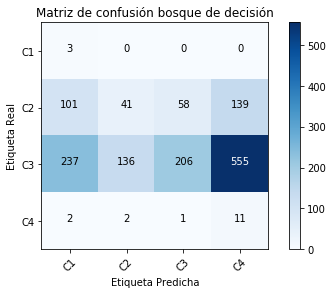

In [210]:
cnf_matrix = confusion_matrix(y_testset, yhat_1_3, labels=['C1','C2','C3','C4'])
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['C1','C2','C3','C4'],normalize= False,  title='Matriz de confusión bosque de decisión')
print (classification_report(y_testset,yhat_1_3))

Regresión Logística

In [ ]:
cnf_matrix = confusion_matrix(y_testset, yhat_3, labels=['C1','C2','C3','C4'])
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['C1','C2','C3','C4'],normalize= False,  title='Matriz de confusión regresión logística')
print (classification_report(y_testset, yhat_3))

Red neuronal

In [ ]:
cnf_matrix = confusion_matrix(y_testset, yhat_4, labels=['C1','C2','C3','C4'])
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['C1','C2','C3','C4'],normalize= False,  title='Matriz de confusión red neuronal')
print (classification_report(y_testset, yhat_4))

Support Vector Machine

In [ ]:
cnf_matrix = confusion_matrix(y_testset, yhat_5, labels=['C1','C2','C3','C4'])
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['C1','C2','C3','C4'],normalize= False,  title='Matriz de confusión SVM')
print (classification_report(y_testset, yhat_5))